# RRT* algorithm

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random
import time

In [19]:
X_EXPAND = 4# [m]
DIST_TH = 0.5 # [m]
R_near = 6 # [m] 

MAP_X_LIM = [0, 60]
MAP_Y_LIM = [0, 60]

gain = 4.5/3.9
LENGTH = 3.9 * gain # [m]
WIDTH = 1.9 * gain # [m]

show_animation  = True

In [20]:
class Node:
    def __init__(self, parent=None, position=None):
        self.parent = parent
        self.position = position
        self.x = self.position[0]
        self.y = self.position[1]
#         self.path_x = path_x
#         self.path_y = path_y
        self.f = 0
  
    def __eq__(self, other):
        if self.position == other.position:
            return True

In [21]:
def collision_check(omap, node):
    nx = node[0]
    ny = node[1]
    ox = omap[0]
    oy = omap[1]
    
    col = False

    for i in range(len(ox)):
        if np.sqrt((nx-ox[i])**2 + (ny-oy[i])**2) < np.sqrt(LENGTH**2/4 + WIDTH**2/4):
            col = True
            break
            
    if nx <= MAP_X_LIM[0] or nx >= MAP_X_LIM[1] or ny <= MAP_Y_LIM[0] or ny >= MAP_Y_LIM[1]:
        col = True

    return col

In [22]:
def select_rand_node():
    _x = random.randint(MAP_X_LIM[0], MAP_X_LIM[1])
    _y = random.randint(MAP_Y_LIM[0], MAP_Y_LIM[1])
    rand_node = (_x, _y)
    
    return rand_node

In [23]:
def find_near_node(rand_node, Tree):
    min_dist = 1e5
    near_node = None
    for i in range(len(Tree)):
        _cand_node = Tree[i]
        _dist = np.sqrt((_cand_node.x - rand_node[0])**2 + (_cand_node.y - rand_node[1])**2)
        if _dist < min_dist:
            min_dist = _dist
            near_node = _cand_node
            
    return near_node

In [24]:
def expand_node(near_node, rand_node, step_size=X_EXPAND):
    x2 = rand_node[0]
    y2 = rand_node[1]
    x1 = near_node.x
    y1 = near_node.y
    
    dx = x2-x1
    dy = y2-y1
    theta = np.arctan2(dy, dx)
    
    dist = np.sqrt(dx**2 + dy**2)
    if dist <= step_size:
        exp_node = rand_node
        exp_dist = dist
    else:
        _x = x1 + step_size*np.cos(theta)
        _y = y1 + step_size*np.sin(theta)
        exp_node = (_x, _y)
        exp_dist = step_size
    
    return exp_dist, exp_node

In [25]:
def check_goal_condition(cur_node, goal_node):
    cur_x = cur_node.x
    cur_y = cur_node.y
    
    goal_x = goal_node.x
    goal_y = goal_node.y
    
    xy_diff = np.sqrt((cur_x - goal_x)**2 + (cur_y - goal_y)**2)
    
    if xy_diff < DIST_TH:
        return True
    else:
        return False

In [26]:
def is_contain(rand_node, Tree):
    contain = False
    for node in Tree:
        if node.x == rand_node[0] and node.y == rand_node[1]:
            contain = True
            
    return contain

In [27]:
def dist(n1, n2):
    return np.sqrt((n1.x - n2.x)**2 + (n1.y - n2.y)**2)

In [28]:
def near(cur_node, Tree, R=10):
    near_set = []
    for node in Tree:
        if dist(cur_node, node) < R:
            near_set.append(node)
            
    return near_set

In [29]:
def choose_parent(cur_node, near_set):
    min_cost = 1e5
    parent = None
    for node in near_set:
        _dist = dist(cur_node, node)
        _cost = node.f + _dist
        if _cost < min_cost:
            min_cost = _cost
            parent = node
    cur_node.f = min_cost
    return parent

In [30]:
def rewire(cur_node, near_set):
    for node in near_set:
        _dist = dist(cur_node, node)
        if node.f > cur_node.f + _dist:
            node.parent = cur_node

In [31]:
# rrt star algorithm
def rrt_star(start, goal, omap):
    
    # initialize
    start_node = Node(None, start)
    goal_node = Node(None, goal)

    Tree = []
    
    Tree.append(start_node)
    
    Is_goal = False
    
    while Is_goal is False:
        # generate random node
        if random.randint(0, 10) > 2:
            rand_node = select_rand_node()
            if (rand_node == start) or (rand_node == goal) or is_contain(rand_node, Tree):
                continue
        else:
            rand_node = goal

        # find the nearest node in Tree
        near_node = find_near_node(rand_node, Tree)  

        # expand the node
        exp_dist, exp_node = expand_node(near_node, rand_node, step_size=X_EXPAND)

        # collision check
        is_collid = False
        if collision_check(omap, exp_node):
            is_collid = True

        # Add the node to tree if collision free
        if is_collid == False:
            child = Node(near_node, exp_node)
            child.f = near_node.f + exp_dist

            # find near nodes
            near_set = near(child, Tree, R=R_near)

            # choose parent
            parent_node = choose_parent(child, near_set)
            child.parent = parent_node
            Tree.append(child)

            # rewiring
            rewire(child, near_set)      
            
            plt.plot(child.x, child.y, 'yo',  markersize=7, alpha=0.2)
            plt.plot([child.x, parent_node.x], [child.y, parent_node.y], 'y')

            # 9) goal check : If goal, get optimal path
            goal_condition = check_goal_condition(child, goal_node)
            if goal_condition == True:
                opt_path = []

                node = child

                while node is not None:
                    opt_path.append(node.position)
                    node = node.parent
#                 print("opt path : ", opt_path[::-1])
#                 print("opt_path_shape : ", np.shape(opt_path))
                return opt_path[::-1]


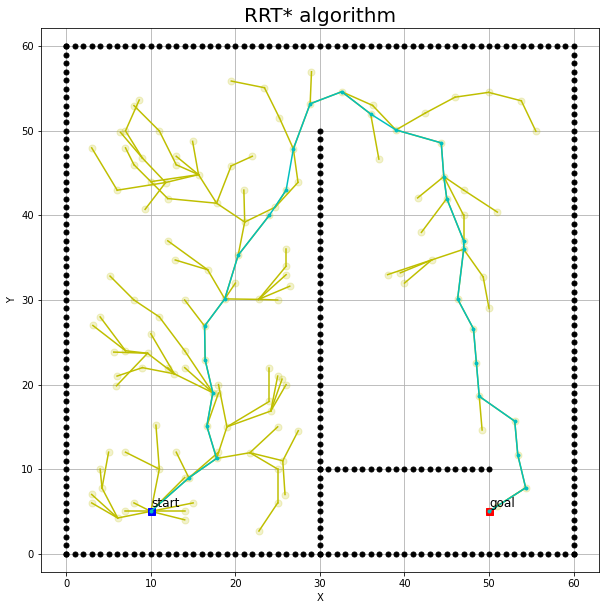

In [33]:
def main():
    
    # iNITIALIZE - 1)start, 2)goal, 3)map
    start = (10, 5) 
    goal = (50, 5)
    
    ox, oy = [], []
    
    for i in range(61):
        ox.append(i)
        oy.append(0)
    for i in range(61):
        ox.append(0)
        oy.append(i)
    for i in range(61):
        ox.append(i)
        oy.append(60)
    for i in range(60):
        ox.append(60)
        oy.append(i)
    for i in range(51):
        ox.append(30)
        oy.append(i)
    for i in range(21):
        ox.append(30+i)
        oy.append(10)
    
    omap = [ox, oy]

    plt.figure(figsize=(10,10))
    
    opt_path = rrt_star(start, goal, omap)
    
    opt_path = np.array(opt_path)

    if show_animation == True:
#         plt.figure(figsize=(10,10))
        plt.plot(start[0], start[1], 'bs',  markersize=7)
        plt.text(start[0], start[1]+0.5, 'start', fontsize=12)
        plt.plot(goal[0], goal[1], 'rs',  markersize=7)
        plt.text(goal[0], goal[1]+0.5, 'goal', fontsize=12)

        plt.plot(ox, oy, '.k',  markersize=10)
        plt.grid(True)
        plt.axis("equal")
        plt.plot(opt_path[:,0], opt_path[:,1], "c.-")
        plt.xlabel("X"), plt.ylabel("Y")
        plt.title("RRT* algorithm", fontsize=20)
        plt.show()
    
    
if __name__ == "__main__":
    main()